In [1]:
from collections import Counter
import pandas as pd
import string
from transformers import AutoTokenizer
import spacy

In [17]:
with open('sample_data/wikitext/wikitext103_test.txt', 'r') as file:
    contents = file.read()

words = contents.split()
df = pd.DataFrame(list(Counter(words).items()), columns=['token', 'count']).sort_values('count', ascending=False).reset_index(drop=True)
df

,token,count
0,the,13988
1,",",11108
2,.,8918
3,of,6731
4,and,5780
...,...,...
20921,uncharted,1
20922,crinkling,1
20923,discernible,1
20924,obliterated,1


In [18]:
df = df[df['token'].apply(lambda w: w  not in string.punctuation)]

# only keeping words that are considered one token by the language model
tokenizer = AutoTokenizer.from_pretrained('google/multiberts-seed_0')
filtered_words = [word for word in df['token'].tolist() if len(tokenizer.tokenize(word)) == 1]
df = df[df['token'].isin(filtered_words)].reset_index(drop=True)

df

,token,count
0,the,13988
1,of,6731
2,and,5780
3,to,4724
4,in,4495
...,...,...
14192,Silence,1
14193,hid,1
14194,eyebrows,1
14195,Straps,1


In [6]:
def get_pos_tags(doc_path):
    nlp = spacy.load('en_core_web_sm')
    nlp.max_length = 2000000
    pos_dict = {}
    with open(doc_path, 'r', encoding='utf-8') as file:
        text = file.read()
        doc = nlp(text)
        for token in doc:
            if token.text in pos_dict and not token.pos_ in pos_dict[token.text]:
                pos_dict[token.text].append(token.pos_)
            else:
                pos_dict[token.text] = [token.pos_]
        
    return pd.DataFrame(list(pos_dict.items()), columns=['token', 'POS'])

In [7]:
document = "sample_data/wikitext/wikitext103_test.txt"
pos_tags = get_pos_tags(document)
pos_tags

,token,POS
0,,[SPACE]
1,Robert,[PROPN]
2,Boulter,[PROPN]
3,is,[AUX]
4,an,[DET]
...,...,...
20889,Author,[NOUN]
20890,credibility,[NOUN]
20891,Ronnie,[PROPN]
20892,Pelkey,[PROPN]


In [20]:
merged_df = pd.merge(df, pos_tags, on='token', how='inner')
merged_df


,token,count,POS
0,the,13988,[DET]
1,of,6731,[ADP]
2,and,5780,[CCONJ]
3,to,4724,"[ADP, PART]"
4,in,4495,[ADP]
...,...,...,...
14190,Silence,1,[PROPN]
14191,hid,1,[VERB]
14192,eyebrows,1,[NOUN]
14193,Straps,1,[NOUN]


In [27]:
merged_df.to_csv('sample_data/wikitext/wikitext_wordbank.tsv', sep='\t', index=None)

In [68]:
df[(df['count'] > 8) & (df['count'] < 512)]

,word,count
27,also,482
28,but,469
29,first,462
30,its,461
31,their,451
...,...,...
2933,Overall,9
2934,directors,9
2935,principal,9
2936,speaking,9


Text(0.5, 1.0, 'Distribution of Word Counts')

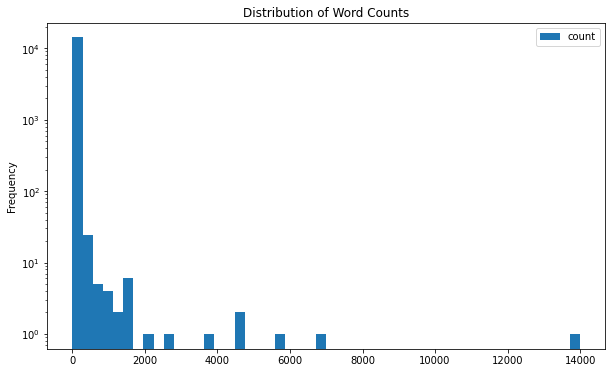

In [69]:
ax = df.plot(kind='hist', bins=50, logy=True, figsize=(10,6))
ax.set_title('Distribution of Word Counts')
